# **MRR for QAC**

* [Introduction](#Introduction)
* [Formula](#Formula)
* [Loading the Data File](#Loading)
* [Generating the ES Data File](#GeneratingES)
* [Generating the WS Data File](#GeneratingWS)
* [Interpreting RR representation](#Interpreting)
* [MRR@10](#MRR)
* [Verification](#Verification)
* [References](#References)

# **Introduction** <a class="anchor"  id="Introduction"></a>
The evaluation of Query Auto-Complete (QAC) performance has two general approaches [23], each of which has its own metric: 
* (1) the **Mean Reciprocal Rank (MRR) metric** that focuses on the quality of ranking and 
* (2) the **Minimum Keystroke Length (MKS) metric** that focuses on savings of a user’s keystroke effort [26].

The focus of this study is ranking performance, and
we compute variants of the widely used MRR metric for evaluating QAC ranking performance [9, 14].
MRR is suitable for evaluating a list of possible responses to a sample of queries, ordered by the probability of correctness. 

In this code, we parse **Enterprise Search(ES)** and **Web Search(WS)** search log files to compute the MRR scores for various cut-offs.  The ES data is from an Apache Solr log file, wherease the WS data is from the AOL dataset published in 2006.

# **Formula** <a class="anchor"  id="Formula"></a>

The Reciprocal Rank (RR) of a query response is the multiplicative inverse of the rank of the first correct answer: 1 for first place, 1⁄3 for third place, or zero if the submitted query is not present in the ranked list [7]. The mean reciprocal rank is the average of the RR results for a sample of queries Q:


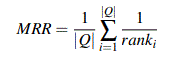


where rank<sub>i</sub> refers to the rank position of the first relevant document for the i<sup>th</sup> query. MRR only considers
the rank of the first relevant candidate (if there are further relevant candidates, they are ignored)

In [1]:
## Library imports
import numpy as np 
import pandas as pd


# **Loading the ES and WS Log Data** <a class="anchor"  id="Loading"></a>

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tcd-qac/mrr-list-node2-All-orig.txt-fat-head-2
/kaggle/input/tcd-qac/mrr.sh
/kaggle/input/tcd-qac/solr.log
/kaggle/input/tcd-qac/mrr-list-v2.txt
/kaggle/input/tcd-qac/mrr-list-v4.txt
/kaggle/input/tcd-qac/mrr-list-v5.txt


In [3]:
# ES = Enterprise Search (solr log data)
# WS = Web Search (AOL Logs from 2006 dataset)
ES_QAC_LOG_DATA="/kaggle/input/tcd-qac/mrr-list.json"
WS_QAC_LOG_DATA="/kaggle/input/tcd-qac/mrr-list-v4.txt"


# **Generating the ES MRR file** <a class="anchor"  id="GeneratingES"></a>

This code in this section requires access to the Solr Index and runs using the bash shell.   We can skip this sections if "ES_QAC_LOG_DATA=skip"

In [4]:
ES_SCRIPT="/kaggle/input/tcd-qac/mrr.sh"
!cp -p /kaggle/input/tcd-qac/mrr.sh /kaggle/working/
!cp -p /kaggle/input/tcd-qac/solr.log /kaggle/working/
!chmod ugo+x /kaggle/working/mrr.sh
!ls -l /kaggle/working/mrr.sh

-rwxr-xr-x 1 nobody nogroup 1629 Jun 16 14:04 /kaggle/working/mrr.sh


In [5]:
import subprocess

rc = subprocess.call("/kaggle/working/mrr.sh")     #scipt takes about 2minutes to run; ouput goes to a file names mrr-list.json

solr.log exists.
FILE var is set to solr.log .
output file (in json format) is mrr-list.json


In [6]:
#!sed -i -e '1h;1!H;$!d;${s/.*//;x};s/\(.*\),/\1 /' mrr-list-v16.json


In [7]:
#double check formatting of mrr data file:
!head -3 mrr-list.json  # each element in the list of lists is in square brackets.
!tail mrr-list.json  # note json format (last comma in list removed) and the final closing square bracket on a newline.

[[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0] 
]


# **Generating the WS MRR file** <a class="anchor"  id="GeneratingWS"></a>

# **Interpreting RR representation** <a class="anchor"  id="Interpreting"></a>
The mrr-list file has been created by the [mrr.sh script ](http://https://github.com/ColinDaly75/Thesis-Supplementary-Information/blob/main/mrr.sh) which parses the solr log files, collecting the postion of selected PREFIX candidates for a given QUERY and assigns an RR score.

The [0,0,0,0,0,1] boolean represention means that, for a user's prefix, the correct candidate (sometimes referred to as **the 'golden' candidate**) was positioned 6th in the list.   Other examples RR representations are shown in the graphic below.

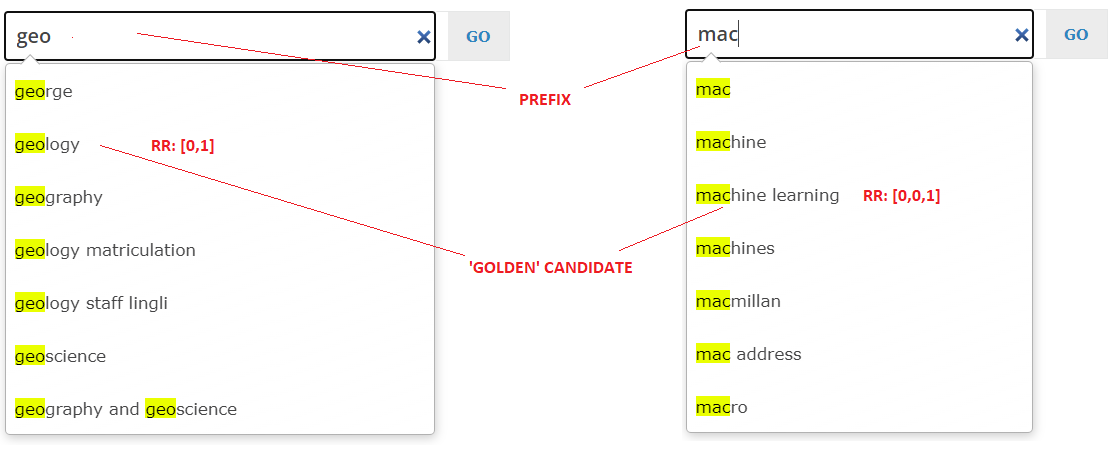

A representation of [1] indicates that the golden candidate was positioned on top of the suggestion lists.  Similarly, a representation of [0] would mean that the golden candidate did not make it onto the list of suggestions. 

Previously recorded queries can provide useful context for any user’s intent and can be leveraged
to suggest auto-completions that are more relevant while adhering to the user’s prefix. [8]. Most Popular Completions (MPC) is the main indicator of historical relevance [9].  MPC is widely used as a QAC baseline and can be regarded as an approximate maximum likelihood estimator [8,9] and hence we use it for our 'gold' standard.   

Limitations of MPC include i) single-objective ranking ii) cold starts iii)echo chamber iv)assumption that a click is a positive vote (rickrolling), iv) MPC assumes that current query popularity distribution will remain the same as previously observed


In [8]:
import json
#with open('/kaggle/input/tcd-qac/mrr-list-v5.txt', 'r') as f:
with open('/kaggle/input/tcd-qac/mrr-list-node2-All-orig.txt-fat-head-2', 'r') as f:
    data = json.load(f)
#print(data)   expected format: [[0], [0, 0, 3], [], [1]', [0], [0], [], [0], [0], [], []]

In [9]:
data_tidy =   [x for x in data if x]     # remove emtpy items in list like [] , new format is [[0], [0, 0, 3], [1], [0], [0]]


# **MRR@10** <a class="anchor"  id="MRR"></a>

We'll use [MRR@10 (Mean Reciprocal Rank)](https://en.wikipedia.org/wiki/Mean_reciprocal_rank), a metric which takes into account only the position of the first relevant document returned into the first 10 documents by each query. 

In [10]:
##Source: https://gist.github.com/bwhite/3726239
def mean_reciprocal_rank(bool_results, k=10):
    bool_results = (np.atleast_1d(r[:k]).nonzero()[0] for r in bool_results)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in bool_results])



In [11]:
print(mean_reciprocal_rank(data,10))
print(mean_reciprocal_rank(data_tidy,10))

0.5335616438356164
0.6833333333333333


# **MRR@7** <a class="anchor"  id="MRR7"></a>

Whenever autocomplete suggestions start to exceed around 10 items on desktop (and fewer on mobile — around 7), users tend to either begin to ignore suggestions (at which point the additional suggestions become mere noise) or spend an inordinate amount of time reading suggestions (effectively halting their search process).

For this reason, the UX team that have designed our Enterprise Search service have limited the number of suggestions to 7 candidates.   For this reason, MRR@7 is the appropriate metric parameter.

We also include MRR@1 for informative purposes.
 


In [12]:
MRR_COUNTS = [1,5, 7, 10]   # higher COUNT must result in a higer score

for COUNT in MRR_COUNTS:
    MRR_COUNT=mean_reciprocal_rank(data_tidy,COUNT)
    print ('The MRR@{}'.format(COUNT),"score is ""%.3f" %MRR_COUNT)
    
# SCOREBOARD history
# 27th-Feb-2024 v2 The MRR@10 score is 0.193
# 27th-Feb-2024 v4 The MRR@10 score is 0.187
# 28th-Feb-2024 v5 The MRR@10 score is 0.193
# 17th-Mar-2024 v6 The MRR@10 score is 0.192
# 27-May-2024   v7 The MRR@10 score is 0.225
# 28-May-2024   fathead node2 The MRR@10 score is 0.683


The MRR@1 score is 0.596
The MRR@5 score is 0.683
The MRR@7 score is 0.683
The MRR@10 score is 0.683


# **Verification** <a class="anchor"  id="Verification"></a>

In [13]:
print(data_tidy)   # should have no empty lists like [] .Caution: data list order is not preserved

[[1], [0], [0], [0], [0, 2], [0], [0], [1], [1], [1], [0], [0, 2], [1], [1], [1], [0], [1], [0, 2], [0, 2], [1], [1], [1], [0, 0, 0, 0, 5], [1], [1], [1], [0, 2], [1], [1], [1], [1], [0, 2], [1], [1], [1], [0], [0], [0, 2], [1], [1], [0, 2], [1], [0, 2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [1], [0], [0, 0, 0, 4]]


In [14]:
!wc -l /kaggle/input/tcd-qac/mrr-list-v5.txt # should match number of elements in data array (below, not count is one higher due last line)

1343 /kaggle/input/tcd-qac/mrr-list-v5.txt


In [15]:
!cat /kaggle/input/tcd-qac/mrr-list-v5.txt  | grep "\[\]" | wc -l   # should match number of elements removed (below)

321


In [16]:
print("Number of elements in 'data' mrr list:",len(data))
print("Number of elements in 'data_tidy' (processed) mrr list:",len(data_tidy))
print("The number of empty list elements, i.e. where qac was unavailable, is:", len(data)-len(data_tidy))  # number of empty list elements, must be a positive number.


Number of elements in 'data' mrr list: 73
Number of elements in 'data_tidy' (processed) mrr list: 57
The number of empty list elements, i.e. where qac was unavailable, is: 16


# **References** <a class="anchor"  id="References"></a>

[23] Y. Chang and H. Demg, Query Understanding for Search Engines, ser. The Information Retrieval Series. Jilin: Springer
International Publishing, 2020, vol. 46.

[26] H. Duan and B. J. Hsu, “Online spelling correction for query completion,” Proceedings of the 20th International Conference on World Wide Web, WWW 2011, pp. 117–126, 2011.

[8] N. Yadav, R. Sen, D. N. Hill, A. Mazumdar, and I. S. Dhillon, “Session-Aware Query Auto-completion using Extreme MultiLabel Ranking,” Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 3835–3844, 8 2021. 

[9] L. Li, H. Deng, A. Dong, Y. Chang, R. BaezaYates, and H. Zha, “Exploring query autocompletion and click logs for contextualaware web search and query suggestion,” 26th International World Wide Web Conference, WWW 2017, pp. 539–548, 2017

[14] F. Cai and M. De Rijke, “A survey of query auto completion in information retrieval,” Foundations and Trends in Information Retrieval, vol. 10, no. 4, pp. 273–363, 2016.

# **ToDo**

1. A/A test incl std-deviation and t-test.  Hypothesis
2. A/B test after implementation of new Feature.  Next Phase.
3. MRR scores for top most poprular 15 queries 
4. explain MPC is used to baseline the 'golden' candidates.  DONE

# **Ablation Analysis**

Ablation/leave-one-out analysis showing the contribution of individual features to the MRR performance across the QAC ranking models. Red line shows impact of on Ranking performance using the additive feature layers. 

A set of experiments in which features in our LTR Ranking model are removed/replaced in order to measure the impact of these features on the performance of the system.


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'Feature': ['FIELDS', 'MPC', 'MFQ', 'AOL', 'TREND', 'QACES'],
    'MRR@1': [0.05,      0.12, 0.09,   0.02,  0.03,    0.03],
    'MRR@3': [0.05,      0.17, 0.10,   0.02,  0.04,    0.03],
    'MRR@7': [0.06,      0.19, 0.11,   0.02,  0.04,    0.04],
    'MRR@10':[0.07,      0.23, 0.13,   0.03,  0.04,    0.04],
}

data = {
    'Feature': ['FIELDS', 'MFQ', 'AOL', 'TREND', 'QACES'],
    'MRR@1': [0.05,      0.09,   0.02,  0.03,    0.03],
    'MRR@3': [0.05,      0.10,   0.02,  0.04,    0.03],
    'MRR@7': [0.06,      0.11,   0.02,  0.04,    0.04],
    'MRR@10':[0.07,      0.13,   0.03,  0.04,    0.04],
}


df = pd.DataFrame(data)
df['Additive_Total'] = df['MRR@10'].cumsum()
print (df)

  Feature  MRR@1  MRR@3  MRR@7  MRR@10  Additive_Total
0  FIELDS   0.05   0.05   0.06    0.07            0.07
1     MFQ   0.09   0.10   0.11    0.13            0.20
2     AOL   0.02   0.02   0.02    0.03            0.23
3   TREND   0.03   0.04   0.04    0.04            0.27
4   QACES   0.03   0.03   0.04    0.04            0.31


Although MPC is typically considered the main indicator of historical relevance~\cite{li-google-2017}, it cannot be included as a feature here (since we already use it as a proxy for ground truth (i.e. the target variable) in our LTR dataset).} This exclusion prevents target leakage, where the model could learn spurious correlations between the predictors (features) and the target variable.

A grouped barplot is used since we have several groups (i.e. 5 features), and subgroups  (i.e. 4 MRR scores) of these groups.

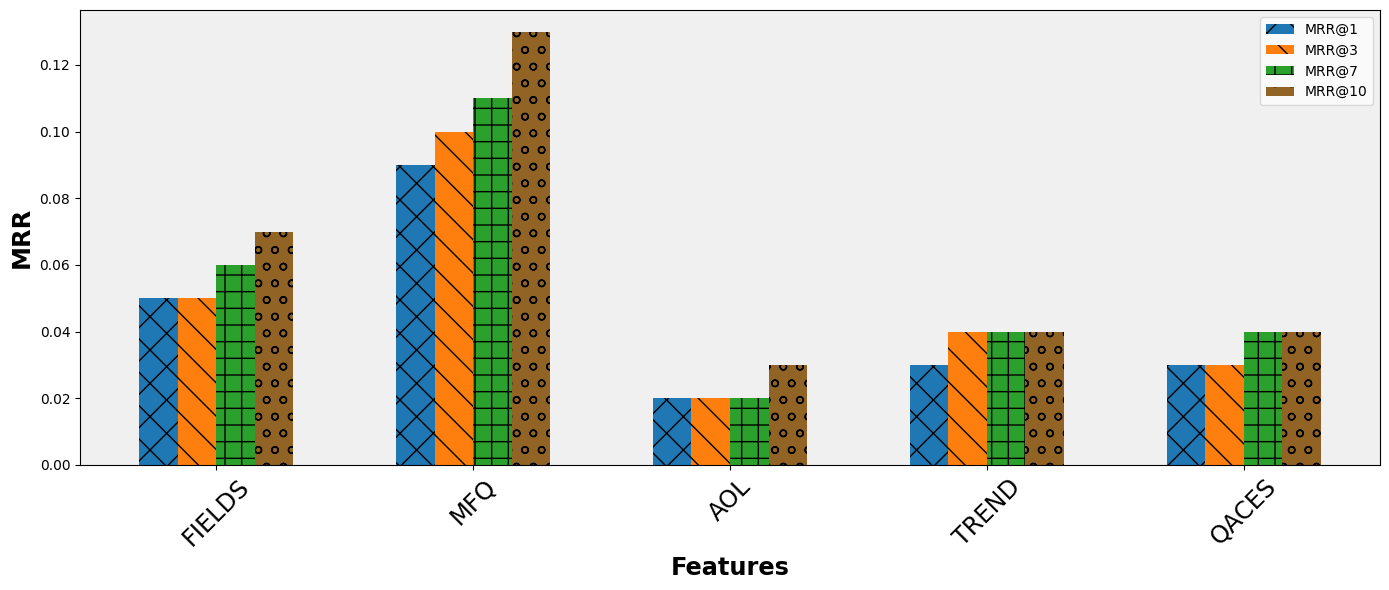

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
#ax2 = ax.twinx()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#916324', '#9467bd']
patterns = ['x', '\\', '+', 'o', '|']

bar_width = 0.15
bar_positions = np.arange(len(df['Feature']))
for i, col in enumerate(['MRR@1', 'MRR@3', 'MRR@7', 'MRR@10']):
    ax.bar(bar_positions + i*bar_width, df[col], bar_width, label=col, color=colors[i], hatch=patterns[i])

#ax2.plot(df['Feature'], df['Additive_Total'], color="red", linestyle="--", linewidth=2)
#line_label = 'Total MRR'
#ax.plot([], [], color="red", linestyle="--", linewidth=2, label=line_label)

legend = ax.legend(loc='upper right', fontsize='medium', title_fontsize='xx-large', fancybox=True)
legend.get_frame().set_alpha(0.7)

ax.set_facecolor('#f0f0f0')
#ax2.set_facecolor('#f0f0f0')
ax.set_xlabel("Features", fontweight='bold',fontsize='xx-large')
ax.set_ylabel("MRR", fontweight='bold',fontsize='xx-large')
#ax2.set_ylabel("MRR", fontweight='bold')
plt.xticks(bar_positions + 1.5*bar_width, df['Feature'], rotation=45,fontsize='xx-large')

plt.tight_layout()
plt.savefig('Fig-QAC-MRR-Ablation.png', bbox_inches='tight')   

plt.show()